<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#проведем-обучение-модели-в-отдельном-GPU-тренажёре" data-toc-modified-id="проведем-обучение-модели-в-отдельном-GPU-тренажёре-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>проведем обучение модели в отдельном GPU-тренажёре</a></span></li><li><span><a href="#Результат-решения-кода-запускаемого-в-отдельном-GPU-тренажёре" data-toc-modified-id="Результат-решения-кода-запускаемого-в-отдельном-GPU-тренажёре-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Результат решения кода запускаемого в отдельном GPU-тренажёре</a></span></li></ul></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

# Определение возраста покупателей

# Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.


# План по выполнению проекта:

- Проведите исследовательский анализ набора фотографий.
- Подготовьте данные к обучению.
- Обучите нейронную сеть и рассчитайте её качество.

## Исследовательский анализ данных

Загрузим библиотеки

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

загрузим данные

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv') 

рассмотрим информацию о данных:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
data.shape

(7591, 2)

In [5]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Построим график распределение возраста в данных

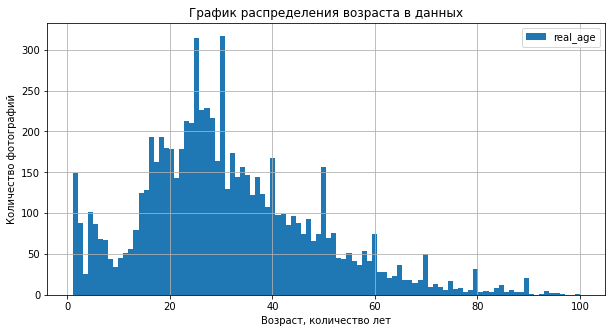

In [7]:
data.plot(kind='hist',figsize=(10,5),bins=100, grid=True)
plt.title('График распределения возраста в данных')
plt.xlabel('Возраст, количество лет')
plt.ylabel('Количество фотографий')
plt.show()

выведим данные количество фотографии по возрастам по убыванию

In [8]:
data['real_age'].value_counts(ascending=False).head(15)

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
22    179
20    178
32    174
40    167
29    164
Name: real_age, dtype: int64

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


выведим на экране 12 фотографий

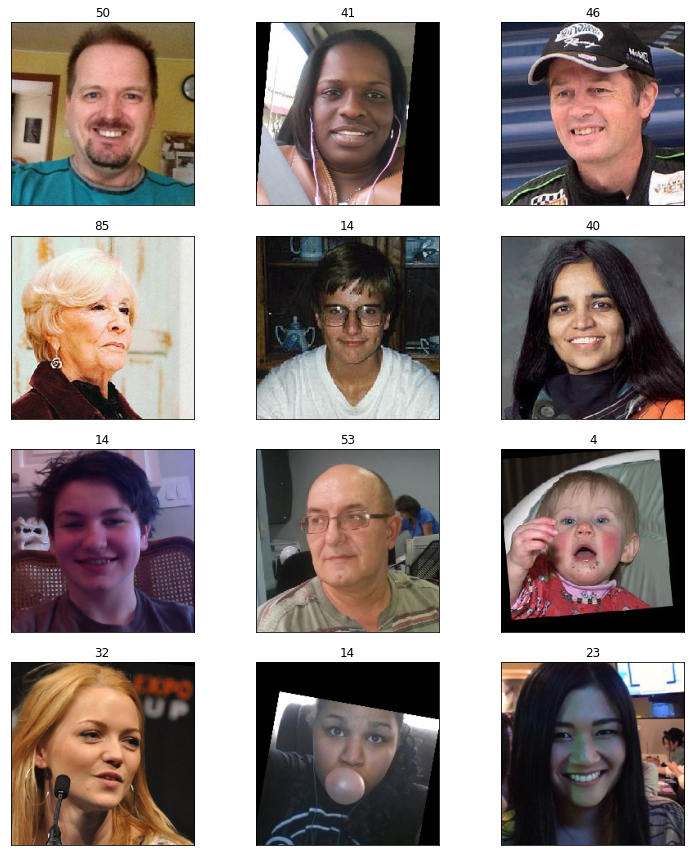

In [10]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(12,12))
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

# Вывод по разделу "исследовательский анализ данных"

В нашем распоряжении предоставлен набор фотографий людей с указанием возраста. данный датасет состоит из двух столбцов (file_name - фотографии и real_age - возраст человека на данной фотографии) и 7951 строк. 

для исследования был построен график распределения возраста в выборке:
- минимальный возраст на фотографиях 1 год а максимальный 100 лет
- большинство фотографий возрастом от 20 до 40 лет, есть пики в 30 и 25 лет, максимальное количество фотографий 317 и 315 штук
- есть локальные пики в юбилейные и значимые даты: такие как 1 год, 16, 18 лет. а дальше 20, 30, 40, 50, 60, 70, 80 лет.

в последней часте вывели фотографии, чтобы посмотреть как устроен дата сет:
- фоторафии со значением возраста
- на фотографиях изображены как обычные люди, так и знаменитости (актеры, спортсмены)
- некоторые фотографии искажены: повернуты, присутствуют черные рамки, размазнанное (пиксельное) лицо, или вовсе на фотографиях присутсвуют артефакты.

В следующей часте работы приступим к обучению модели.

## Обучение модели

### проведем обучение модели в отдельном GPU-тренажёре

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
    data = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25,
                                      horizontal_flip=True)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    data = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr = 0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5, steps_per_epoch=None, validation_steps=None):


    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

### Результат решения кода запускаемого в отдельном GPU-тренажёре

```

Train for 178 steps, validate for 60 steps
Epoch 1/5
2023-10-30 04:49:11.590291: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-10-30 04:49:12.733785: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 67s - loss: 242.1199 - mae: 11.1028 - val_loss: 923.6543 - val_mae: 25.5824
Epoch 2/5
178/178 - 38s - loss: 76.5627 - mae: 6.6286 - val_loss: 746.8957 - val_mae: 22.1505
Epoch 3/5
178/178 - 38s - loss: 49.7224 - mae: 5.3756 - val_loss: 245.9899 - val_mae: 11.4408
Epoch 4/5
178/178 - 38s - loss: 35.1119 - mae: 4.5205 - val_loss: 112.7239 - val_mae: 8.0609
Epoch 5/5
178/178 - 38s - loss: 26.7383 - mae: 3.9729 - val_loss: 81.0868 - val_mae: 6.9099
WARNING:tensorflow:sample_weight modes were coerced from
    to  
  ...
  ['...']
60/60 - 10s - loss: 81.0868 - mae: 6.9099
Test MAE: 6.9099

```

## Анализ обученной модели

Целью работы было построить и обучить свёрточную нейронную сеть на датасете с фотографиями людей, которя поможет определять возраст человека по изображению с камеры. Необходимо добиться значения MAE на тестовой выборке не больше 8.

В нашем распоряжении предоставлен набор фотографий людей с указанием возраста. данный датасет состоит из двух столбцов (file_name - фотографии и real_age - возраст человека на данной фотографии) и 7951 строк.
фоторафии с значение возраста. На фотографиях изображены как обычные люди, так и знаменитости (актеры, спортсмены)
некоторые фотографии искажены: повернуты, присутствуют черные рамки, размазнанное (пиксельное) лицо, или вовсе на фотографиях присутсвуют артефакты.

Была построена нейронная сеть на основе свёрточной сети ResNet50 предобученной на ImageNet. Добавили слой GlobalAveragePooling2D и слой Dense с одним выходом и функцией активации relu. оптимизированы параметры с алгоритмом Adam, где learning_rate = 0.0001. Размер батча: 32 (batch_size=32 в функциях загрузки данных). так же использовал отзеркаливание изображений при помощи параметра horizontal_flip=True. В качестве функции потерь использовалась MSE, метрика качества - MAE.

Для тестирования модели было применено 5 эпох, epochs = 5 в функции train_model, добились MAE 6.9099 на тестовой выборке, что требовалось от цели проекта получить мае меньше 8, а еще лучше меньше 7. Увеличение количество эпох до 7 приводит к переобучению модели, что так же негативно влияет на результат.  

Однако, так как метрика качества - MAE измеряется в абсолютных величинах, то получается, что  модель ошибается в возрасте человека на 6,9 лет. Следовательно для человека с 25 лет это разница не сильно критична (в подборе каких либо товаров), тогда как если человеку 22 года, то система с погрешность в 6,9 лет может указать что клиенту к примеру 15-17 лет и отказать в продаже алкоголя, или наоборот 17 летнему разрешит продажу, что может негативно повлиять на бизнес.

Скорее всего такая погрешность связана с тем что в текущем датасете, фотографий людей школьного возраста и людей за 40 лет меньше чем 20 до 40. а так же из за резких пиков в юбилейные и значимые даты: такие как 1 год, 16, 18 лет. а дальше 20, 30, 40, 50, 60, 70, 80 лет. Если датасет дополнить объектами в тех возрастных категориях, в которых количество фотографий мало, то качество модели будет лучше. 

Таким образом цель проекта была достигнута. Точность предсказания возраста нашей моделью составила 6.9099. Данную модель можно использовать в работе.